<a href="https://colab.research.google.com/github/VKarpick/powerplay/blob/main/powerplay_gam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Packages

In [1]:
!pip install hockey-rink pygam

     |████████████████████████████████| 1.8 MB 34.8 MB/s 
  Created wheel for hockey-rink: filename=hockey_rink-0.1.7-py3-none-any.whl size=34876 sha256=a00a26999da33387f38eb43b7eb502ff3be85ca27cc293982801dd0f1722090b
  Stored in directory: /root/.cache/pip/wheels/9b/9c/06/217d4c3a942284788e7fce440ef4e47a8d032cdceb372ff7ec
Successfully built hockey-rink


In [2]:
from hockey_rink import Rink
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pygam import GAM
from pygam.terms import TermList, FactorTerm, SplineTerm, TensorTerm
from sklearn.preprocessing import StandardScaler
import warnings

# Transforming the Data

The features to be used in the GAM are:
- x and y coordinates of the puckhandler.
 - These will be symmetrized so everything is considered to have happened in the same half of the ozone.
- Proportion of area available to the puckhandler in the previous frame.
- How the puck was acquired from the previous frame:
 - Continuation: the puck carrier maintained control of the puck.
 - Puck Recovery: either a recovery of a loose puck or a takeaway.
 - Reception: gained control off a pass.
 - Retained: the puck carrier maintained control of the puck but the data for the previous frame was unavailable.
 - Zone Entry: first frame upon entering the zone.
- Team on the powerplay.
- Team on the penalty kill.
- A binary variable denoting whether or not the proportion of area from the previous frame is available.
 - This will be used as a type of gating mechanism to remove the proportions from the calculation when not available.

In [3]:
MAX_EVALS = 100

filename = "https://raw.githubusercontent.com/VKarpick/powerplay/main/data/powerplay_coords.csv"
coords_df = pd.read_csv(filename)
standard_scaler = StandardScaler()

In [4]:
target = coords_df.available_pct

In [5]:
numeric_columns = ["x", "y", "previous_available"]
categorical_columns = ["acquisition", "team_name", "opponent"]

features = coords_df.copy()[numeric_columns + categorical_columns]

# move everything to the same half of the rink
features.x = (features.x - 100).abs()
features.y = (features.y - 42.5).abs()

# keep everything within the bounds of the ozone, ignoring the curve in the boards
features.x = features.x.clip(25, 100)
features.y = features.y.clip(0, 42.5)

# standardize numeric columns
features[numeric_columns] = standard_scaler.fit_transform(
    features[numeric_columns]
)

# create separate acquisition category for continuation of puck control
has_previous = ~features.previous_available.isna()
features.loc[has_previous, "acquisition"] = "Continuation"

# convert categorical columns to numbers for use in factor terms
cat_codes = {}
for categorical_column in categorical_columns:
    factorized_codes = features[categorical_column].factorize()
    features[categorical_column] = factorized_codes[0]
    cat_codes[categorical_column] = list(enumerate(factorized_codes[1]))

# binary variable to be used as a gate for whether or not to use previous_area
features["is_continuation"] = has_previous.astype(int)

# can't have NA values
# gating will prevent previous_available from being where it oughtn't
features.previous_available = features.previous_available.fillna(0)

In [6]:
features.join(target).head()

,x,y,previous_available,acquisition,team_name,opponent,is_continuation,available_pct
0,1.900041,-0.118411,0.000000,0,0,0,0,0.090479
1,1.888596,-0.088380,1.135133,1,0,0,1,0.089837
2,1.896290,-0.048832,1.118577,1,0,0,1,0.084462
3,1.896118,-0.014697,0.980132,1,0,0,1,0.085175
4,1.905860,-0.012139,0.998495,1,0,0,1,0.085134


In [7]:
list(enumerate(features.columns))

[(0, 'x'),
 (1, 'y'),
 (2, 'previous_available'),
 (3, 'acquisition'),
 (4, 'team_name'),
 (5, 'opponent'),
 (6, 'is_continuation')]

The GAM will include:
- An interaction term for the coordinates.
- A spline term for the previous area available, with is_continuation used as an indicator variable to multiply by 0 when unavailable.
- Factor terms for the remaining features.

In [8]:
def get_terms(params):
    return TermList(
        # coordinates
        TensorTerm(
            0, 1, 
            n_splines=[int(params["x_splines"]), int(params["y_splines"])],
            lam=[params["x_lam"], params["y_lam"]],
        ),
        # only consider previous area for continuation plays
        SplineTerm(
            2, by=6, 
            n_splines=int(params["area_splines"]),
            lam=params["area_lam"]
        ),
        # categoricals
        *[FactorTerm(i, lam=params[f"categorical_lam{i}"]) for i in range(3, 6)],
    )

# Hyperparameter Tuning

Parameters to be tuned:
- The number of splines on the tensor term for the coordinates and the spline term for previous area.
- Smoothing / L2 penalties on all terms.

In [9]:
lam_names = (
    ["x_lam", "y_lam", "area_lam"] 
    + [f"categorical_lam{i}" for i in range(3, 6)]
)

space = {
    "x_splines": hp.quniform("x_splines", 10, 30, 1),
    "y_splines": hp.quniform("y_splines", 10, 30, 1),
    "area_splines": hp.quniform("area_splines", 10, 30, 1),
    **{
        lam_name: hp.loguniform(lam_name, np.log(0.01), np.log(100.0))
        for lam_name in lam_names
    },
}

The GAM uses a logit link with a binomial distribution to predict proportions.  

UBRE is used as the loss because the target variable is bounded.  

Warnings are suppressed because of an underflow issue on a summary statistic that doesn't affect the actual model.

In [10]:
best_model = None
best_loss = np.Inf


def objective(params):
    global best_model, best_loss

    terms = get_terms(params)
    gam = GAM(terms=terms, link="logit", distribution="binomial")
    gam.fit(features, target)

    loss = gam.statistics_["UBRE"]

    if loss < best_loss:
        best_loss = loss
        best_model = gam

    return {"loss": loss, "params": params, "status": STATUS_OK}


trials = Trials()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=MAX_EVALS,
        trials=trials,
        rstate=np.random.RandomState(42)
    )

100%|██████████| 100/100 [09:07<00:00,  5.47s/it, best loss: 2.0052454035419536]


In [11]:
trials_df = pd.DataFrame(trials.trials)
results = pd.json_normalize(trials_df.result)
trials_df = trials_df.join(results)

In [12]:
pickle.dump(best_model, open("powerplay_gam.pkl", "wb"))
trials_df.to_csv("powerplay_gam_trials.csv", index=False)

# Inspecting the Results

In addition to plotting the values returned from the partial dependency function, the values will be compared to the change they have in the intercept.  

For example, if the intercept is 0.5 and the partial dependence including the intercept causes the prediction to be 0.4, a value of -0.1 will be returned.  

This way allows results to be interpreted as:
- Negative values = presence of feature associated with available space being closed off.
- Positive values = presence of feature associated with open ice being gained.

In [13]:
def compute_model_link(values):
    return best_model.link.mu(values, best_model.distribution)


intercept = best_model.coef_[-1]
intercept_link = compute_model_link(intercept)


def compute_link_values(values):
    return compute_model_link(values + intercept) - intercept_link


intercept, intercept_link

(-2.700509626683815, 0.06294329084895085)

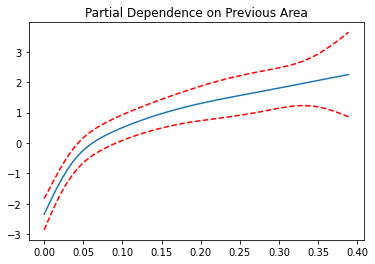

In [14]:
term_idx = 1
term = best_model.terms[term_idx]

XX = best_model.generate_X_grid(term=term_idx)
pdep, confi = best_model.partial_dependence(term=term_idx, X=XX, width=0.95)

previous_area = standard_scaler.inverse_transform(XX[:, :3])[:, -1]

plt.plot(previous_area, pdep)
plt.plot(previous_area, confi, c="r", ls="--")
plt.title("Partial Dependence on Previous Area");

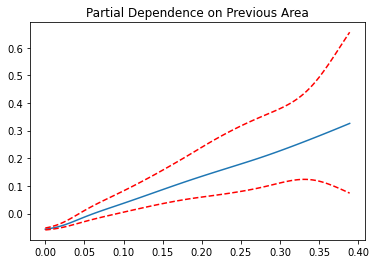

In [15]:
plt.plot(previous_area, compute_link_values(pdep))
plt.plot(previous_area, compute_link_values(confi), c="r", ls="--")
plt.title("Partial Dependence on Previous Area");

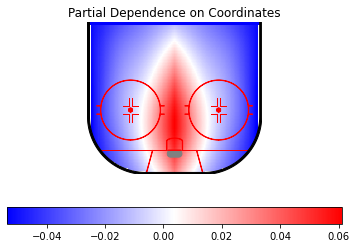

In [16]:
XX = best_model.generate_X_grid(term=0, meshgrid=True)
Z = best_model.partial_dependence(term=0, X=XX, meshgrid=True)

XX_df = pd.DataFrame(zip(XX[0].flatten(), XX[1].flatten()), columns=["x", "y"])
XX_df["previous_available"] = 0
rink_coords = standard_scaler.inverse_transform(XX_df)[:, :2]

rink = Rink(rotation=270)
ax = rink.draw(display_range="ozone");
heatmap = rink.heatmap(
    *zip(*rink_coords), 
    values=Z.flatten(), 
    statistic="mean",
    symmetrize=True, 
    binsize=0.5,
    cmap="bwr", 
    ax=ax
)
plt.colorbar(heatmap, ax=ax, orientation="horizontal")
ax.set_title("Partial Dependence on Coordinates");

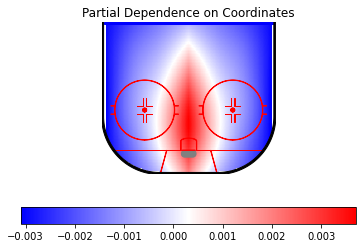

In [17]:
rink = Rink(rotation=270)
ax = rink.draw(display_range="ozone");
heatmap = rink.heatmap(
    *zip(*rink_coords), 
    values=compute_link_values(Z.flatten()), 
    statistic="mean",
    symmetrize=True, 
    binsize=0.5,
    cmap="bwr", 
    ax=ax,
)
plt.colorbar(heatmap, ax=ax, orientation="horizontal")
ax.set_title("Partial Dependence on Coordinates");

In [18]:
acquisition_indices = best_model.terms.get_coef_indices(2)
list(zip(
    cat_codes["acquisition"], 
    best_model.coef_[acquisition_indices],
    compute_link_values(best_model.coef_[acquisition_indices]),
))

[((0, 'Retained'), 0.008596309473886113, 0.0005089316112372733),
 ((1, 'Continuation'), 2.0508347445980603e-08, 1.209611744101835e-09),
 ((2, 'Reception'), 0.0997662984900362, 0.006147305474990289),
 ((3, 'Puck Recovery'), -0.0357660005469762, -0.002076843830315478),
 ((4, 'Zone Entry'), -0.07259663007634186, -0.004148407326195071)]

In [19]:
team_indices = best_model.terms.get_coef_indices(3)
list(zip(
    cat_codes["team_name"], 
    best_model.coef_[team_indices],
    compute_link_values(best_model.coef_[team_indices]),
))

[((0, 'Canada'), 0.008622208549641136, 0.0005104707080965387),
 ((1, 'USA'), -0.0012667200893555731, -7.467161574205294e-05),
 ((2, 'Finland'), -0.0019098770300241467, -0.0001125532988412864),
 ((3, 'ROC'), 0.0048061938252300955, 0.0002840723687187324),
 ((4, 'Switzerland'), -0.010251806465168524, -0.0006019637923575308)]

In [20]:
opponent_indices = best_model.terms.get_coef_indices(4)
list(zip(
    cat_codes["opponent"], 
    best_model.coef_[opponent_indices],
    compute_link_values(best_model.coef_[opponent_indices]),
))

[((0, 'USA'), -0.0017569432065402772, -0.00010354748891963639),
 ((1, 'Canada'), -0.008617083543843523, -0.0005063378560096546),
 ((2, 'ROC'), 0.0072337850190101905, 0.00042801032637553027),
 ((3, 'Finland'), 0.004182177676435523, 0.0002471221741379426),
 ((4, 'Switzerland'), -0.0010419365180204818, -6.142693043212355e-05)]